# Système solaire (simulations numériques en Python)

[vidéo d'illustration](https://www.youtube.com/watch?v=oL14Y5qqagk)

## Description du modèle testé et objectif suivi

Chacun des $N$ astres inclus dans le modèle a une position $\vec{p_n}$ et une vitesse $\vec{v_n}$ dans le référentiel inertiel [ICRS](https://fr.wikipedia.org/wiki/Syst%C3%A8me_de_r%C3%A9f%C3%A9rence_c%C3%A9leste_international).

L'équation d'état qui régit le mouvement de ces astres fait aussi intervenir leur [paramètre gravitationnel standard](https://fr.wikipedia.org/wiki/Param%C3%A8tre_gravitationnel_standard) noté $\mu_k$ :
\begin{align}
\frac{d\vec{p_n}}{dt}&=\vec{v_n}\\
\frac{d\vec{v_n}}{dt}&=\sum_{1\leq k \leq N,k \neq n}-\mu_k\frac{\vec{p_n}-\vec{p_k}}{\left\lVert\vec{p_n}-\vec{p_k}\right\lVert^3}
\end{align}

Ce modèle fait donc appel à la mécanique classique et aux lois de Newton pour la gravitation. Les valeurs des paramètres gravitationnels standards $\mu_k$ sont repris de l'article ["The JPL Planetary and Lunar Ephemerides DE440 and DE441"](https://iopscience.iop.org/article/10.3847/1538-3881/abd414/pdf) (Table 2, page 5).

Le programme de simulation qui résout numériquement l'équation d'état proposée permet de réaliser ensuite des comparaisons avec les [éphémérides fournies par le JPL](https://ssd.jpl.nasa.gov/horizons/app.html#/). Les conditions initiales pour les simulations numériques correspondent à la première ligne des fichiers importés du site du JPL, donc aux positions et vitesses des astres à la date de début choisie. Le pas de calcul pour les simulations numériques est le même que celui choisi pour les fichiers importés, afin de faciliter les comparaisons.

L'objectif est de montrer que la modélisation simplifiée qui est proposée donne cependant des résultats qui restent cohérents avec ces éphémérides très précises du JPL.

## Code initial à exécuter avant d'utiliser les fonctions (fichier **astro.py**)

In [ ]:
# -*- coding: utf-8 -*-
"""
Astro

Liste des fonctions :
---------------------
lire_info_csv(nom)
liste_id()
req_jpl_read(id,debut='2023-01-01 00:00:00',fin='2043-01-01 00:00:00',pas='8 h')
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2023-01-01 00:00:00',fin='2043-01-01 00:00:00',pas='8 h')
jpl_read(nom,nblignes=-1)
convert_jpl_to_csv(Planetes='Planetes.csv')
jpl_affiche(Astre)
eq_kepler(M,e)
calc_param_orb(PV,mu)
calc_param_kepler(PV,mu)
orbite_kepler(Astre1='Soleil',Astre2='Mercure',Planetes='Planetes.csv',
    Astre1_k='Soleil_k',Astre2_k='Mercure_k',Planetes_k='Planetes_k.csv')
trace_param_orb(Nature,Unite,Astre1,Astre2,param_a,param_b,label_a,label_b,dates_a,dates_b)
param_orb_cal_jpl(Astre1='Soleil',Astre2='Mercure',Planetes='Planetes.csv',Param_orb='Mercure_param_orb.csv')
param_orb_comp(Astre1_a='Soleil',Astre2_a='Mercure',Astre1_b='Soleil_simu',Astre2_b='Mercure_simu',
    Planetes='Planetes.csv')
rk4(f,t,y0)
rk8(f,t,y0)
equ_dyn_systsol(y,mu)
trace3D_traj(Astre1,Astre2,XYZ)
trace3D_err(Astre1,Astre2,XYZ_err)
trace2D_err(Astre1,Astre2,XYZ_err,dates)
trace(Astre1='Terre',Astre2='Lune')
compare(Astre1_a='Terre',Astre2_a='Lune',Astre1_b='Terre_simu',Astre2_b='Lune_simu')
simu_systsol_save(Planetes='Planetes.csv',methode='rk8')
--------------------
@author KM (29/06/2023)
"""

import numpy as np
from numpy.linalg import norm
import time
from datetime import datetime
import pandas as pd
import requests as rq
import io
import matplotlib.pyplot as plt

# Lecture des fichiers CSV (liste des planètes ou éphémérides des planètes)
def lire_info_csv(nom):
    df=pd.read_csv(nom)
    return df

# Liste des identifiants des astres
def liste_id():
    rep=rq.get('https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=\'MB\'')
    print(rep.content.decode())

# requête avec l'API du JPL
# id : identifiant de l'astre (lancer liste_id() pour avoir la liste des identifiants)
# debut,fin,pas : intervalle de temps sélectionné, et le pas temporel
def req_jpl_read(id,debut='2023-01-01 00:00:00',fin='2043-01-01 00:00:00',pas='8 h'):
    # envoi de la requête (CENTER='@SSB' : Solar System Barycenter)
    rep=rq.get('https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=\''+str(id)+'\'&OBJ_DATA=\'YES\'&MAKE_EPHEM=\'YES\'&EPHEM_TYPE=\'VECTORS\'&VEC_TABLE=\'2\'&CSV_FORMAT=\'YES\'&CENTER=\'@SSB\'&START_TIME=\''+debut+'\'&STOP_TIME=\''+fin+'\'&STEP_SIZE=\''+pas+'\'')
    # récupération et traitement du contenu en retour de la requête
    f=io.StringIO(rep.content.decode())
    lines=f.readlines()
    for line in lines:
        if line.find('$$SOE') != -1:
            debut=lines.index(line)
        if line.find('$$EOE') != -1:
            nlignes=lines.index(line)-debut-1
    f.close()
    # liste des lignes à ne pas prendre en compte
    skip=[n for n in range(0,debut-2)]
    skip.append(debut-1),skip.append(debut)
    # lecture du fichier de données
    f=io.StringIO(rep.content.decode())
    df=pd.read_csv(f,skiprows=skip,nrows=nlignes)
    f.close()
    # élimination de la dernière colonne qui est vide
    df = df.drop(df.columns[-1], axis=1)
    # format datetime pour les dates (en colonne 1)
    dates=pd.to_datetime(df.iloc[:,1],format=' A.D. %Y-%b-%d %H:%M:%S.%f')
    df = df.drop(df.columns[1], axis=1)
    df.insert(1,'DATES',dates)
    # noms des colonnes sans espace
    noms_col=[df.columns.values[n].strip() for n in range(len(df.columns.values))]
    df.columns=noms_col
    return df

# Les données initialement téléchargées à partir du site "JPL Horizons"
# sont reproduites dans un format plus pratique, pour d'autres utilisations
def convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2023-01-01 00:00:00',fin='2043-01-01 00:00:00',pas='8 h'):
    # Lecture des informations sur les astres
    df_planetes=pd.read_csv(Planetes)
    # Nombre d'astres considérés pour la conversion de fichier
    N=len(df_planetes)
    # sauvegarde au format csv
    for n in range(N):
        print('Données pour '+df_planetes.loc[n,'Nom'])
        df=req_jpl_read(df_planetes.loc[n,'id'],debut,fin,pas)
        df.to_csv(df_planetes.loc[n,'Nom']+'.csv',index=False)

# Lecture du fichier "nom" contenant les éphémérides JPL de l'astre désigné
# on lit toutes les lignes si nblignes reste égal à -1
# on lit nblignes sinon
def jpl_read(nom,nblignes=-1):
    # recherche des délimiteurs de début et fin
    f=open(nom,'r')
    lines=f.readlines()
    for line in lines:
        if line.find('$$SOE') != -1:
            debut=lines.index(line)
        if line.find('$$EOE') != -1:
            nlignes=lines.index(line)-debut-1
    f.close()
    if nblignes != -1:
        nlignes=nblignes
    # liste des lignes à ne pas prendre en compte
    skip=[n for n in range(0,debut-2)]
    skip.append(debut-1),skip.append(debut)
    # lecture du fichier de données
    df=pd.read_csv(nom,skiprows=skip,nrows=nlignes)
    # élimination de la dernière colonne qui est vide
    df = df.drop(df.columns[-1], axis=1)
    # format datetime pour les dates (en colonne 1)
    dates=pd.to_datetime(df.iloc[:,1],format=' A.D. %Y-%b-%d %H:%M:%S.%f')
    df = df.drop(df.columns[1], axis=1)
    df.insert(1,'DATES',dates)
    # noms des colonnes sans espace
    noms_col=[df.columns.values[n].strip() for n in range(len(df.columns.values))]
    df.columns=noms_col
    return df

# Les fichiers initialement téléchargés à partir du site "JPL Horizons"
# sont reproduits dans un format plus pratique, pour d'autres utilisations
def convert_jpl_to_csv(Planetes='Planetes.csv'):
    # Lecture des informations sur les astres
    df_planetes=lire_info_csv(Planetes)
    # Nombre d'astres considérés pour la conversion de fichier
    N=len(df_planetes)
    # sauvegarde au format csv
    for n in range(N):
        df=jpl_read(df_planetes.loc[n,'Nom']+'.txt')
        df.to_csv(df_planetes.loc[n,'Nom']+'.csv',index=False)

# Affichage des données du fichier contenant les éphémérides de l'astre désigné
def jpl_affiche(Astre):
    df=pd.read_csv(Astre+'.csv')
    print('**********')
    # noms des colonnes
    print('>>>noms des colonnes :'),print(df.columns.values)
    # type de chaque colonne
    print('\n>>>types des colonnes :'),print(df.dtypes)
    # contenu du dataframe
    print('\n>>>aperçu du contenu :'),print(df)
    print('**********')

# L'anomalie moyenne M permet d'obtenir l'anomalie excentrique
# (résolution itérative de l'équation de Kepler M=E-e*sin(E))
def eq_kepler(M,e):
    E=np.pi
    M=np.remainder(M,2*np.pi)
    for n in range(5):
        E=(M-e*(E*np.cos(E)-np.sin(E)))/(1-e*np.cos(E))
    return E

# Calcul des paramètres orbitaux à partir de la position r et la vitesse V
# à un instant donné.
# e : vecteur excentricité (pointe vers le périastre)
# i : inclinaison du plan de l'orbite osculatrice
# Omega : longitude du noeud ascendant
# omega : argument du périastre
def calc_param_orb(PV,mu):
    r=PV[:,0:3];V=PV[:,3:6]
    I=np.array([1,0,0]);J=np.array([0,1,0]);K=np.array([0,0,1])
    h=np.cross(r,V);n=np.cross(K,h)
    e=np.cross(V,h)/mu-(r.T/norm(r,axis=1)).T
    test=np.sum(J*n,axis=1)
    Omega=(180/np.pi)*np.arccos(np.sum(I*n,axis=1)/norm(n,axis=1))
    Omega[test<0]=360-Omega[test<0]
    i=(180/np.pi)*np.arccos(np.sum(K*h,axis=1)/norm(h,axis=1))
    test=np.sum(K*e,axis=1)
    omega=(180/np.pi)*np.arccos(np.sum(e*n,axis=1)/(norm(e,axis=1)*norm(n,axis=1)))
    omega[test<0]=360-omega[test<0]
    return e,i,Omega,omega

# Calcul des élément permettant de décrire le mouvement sur une orbite de Kepler,
# à partir de la position r et la vitesse V
# a : demi grand axe de l'ellipse en km
# e : vecteur excentricité  (pointe vers le périastre)
# T : période de l'orbite en secondes
# M0 : anomalie moyenne initiale
# CB : matrice de changement de base (P,Q,W) vers (I,J,K)
def calc_param_kepler(PV,mu):
    r=PV[0:3];V=PV[3:6]
    I=np.array([1,0,0]);J=np.array([0,1,0]);K=np.array([0,0,1])
    h=np.cross(r,V);n=np.cross(K,h)
    e=np.cross(V,h)/mu-r/norm(r)
    a=mu/(2*mu/norm(r)-norm(V)**2)
    T=2*np.pi*np.sqrt(a**3/mu)
    W=h/norm(h);P=e/norm(e);Q=np.cross(W,P)
    CB=np.array([P,Q,W]).T
    E=np.arccos((1-norm(r)/a)/norm(e))
    test=np.sum(Q*r)
    if (test<0):
        E=2*np.pi-E
    M0=E-norm(e)*np.sin(E)
    return a,e,T,M0,CB

# Génération du fichier contenant l'orbite de Kepler de l'astre mentionné,
# avec les conditions initiales prises dans les éphémérides.
def orbite_kepler(Astre1='Soleil',Astre2='Mercure',Planetes='Planetes.csv',
    Astre1_k='Soleil_k',Astre2_k='Mercure_k',Planetes_k='Planetes_k.csv'):
    # Lecture des informations sur les astres
    df_planetes=lire_info_csv(Planetes)
    n1=df_planetes.index[df_planetes['Nom']==Astre1][0]
    n2=df_planetes.index[df_planetes['Nom']==Astre2][0]
    mu=df_planetes.loc[n1,'mu']+df_planetes.loc[n2,'mu']
    # Génération du fichier liste avec les deux astres
    df_plank=pd.DataFrame({'Nom': [Astre1_k, Astre2_k], 'mu': [mu, 0], 'units': ['km^3 s^-2','km^3 s^-2']})
    df_plank.to_csv(Planetes_k,index=False)
    # Lecture des valeurs initiales
    df_Astre1=pd.read_csv(Astre1+'.csv');df_Astre2=pd.read_csv(Astre2+'.csv')
    # Vecteur temps pour le calcul de l'orbite
    df_temps=pd.read_csv(Astre1+'.csv')
    t_orb=3600*24*(df_temps.loc[:,'JDTDB']-df_temps.loc[0,'JDTDB'])
    dates=pd.to_datetime(df_Astre1.loc[:,'DATES'])
    # Récupération des valeurs initiales pour les deux astres choisis
    PV1=np.array(df_Astre1.loc[0,['X','Y','Z','VX','VY','VZ']].tolist())
    PV2=np.array(df_Astre2.loc[0,['X','Y','Z','VX','VY','VZ']].tolist())
    PV=PV2-PV1
    a,e,T,M0,CB=calc_param_kepler(PV,mu)
    # Génération de l'anomalie moyenne
    M=M0+2*np.pi*t_orb/T
    # Génération de l'anomalie excentrique
    E=np.array([eq_kepler(M[n],norm(e)) for n in range(len(t_orb))])
    # Génération de l'anomalie vraie
    theta=2*np.arctan(np.sqrt((1+norm(e))/(1-norm(e)))*np.tan(E/2))
    # Rayon vecteur
    r=a*(1-norm(e)*np.cos(E))
    # Coordonnées de l'astre dans le plan orbital (P,Q), repère (P,Q,W)
    x=r*np.cos(theta);y=r*np.sin(theta);z=np.zeros(len(t_orb))
    # Vitesse de l'astre dans le plan orbital
    vx=-(np.sqrt(mu*a)/r)*np.sin(E)
    vy=(np.sqrt(mu*a)/r)*np.sqrt(1-norm(e)**2)*np.cos(E)
    vz=np.zeros(len(t_orb))
    xyz=np.concatenate(([x],[y],[z]))
    vxvyvz=np.concatenate(([vx],[vy],[vz]))
    # Changement de base vers le repère (I,J,K)
    XYZ2=(CB@xyz).T
    XYZ1=np.zeros(np.shape(XYZ2))
    VXVYVZ2=(CB@vxvyvz).T
    VXVYVZ1=np.zeros(np.shape(VXVYVZ2))
    # Génération des fichiers pour mémoriser les résultats
    df_Astre1k=df_Astre1.copy()
    df_Astre1k = df_Astre1k.drop(df_Astre1.columns[2:], axis=1)
    df_Astre1k.insert(2,'X',XYZ1[:,0])
    df_Astre1k.insert(3,'Y',XYZ1[:,1])
    df_Astre1k.insert(4,'Z',XYZ1[:,2])
    df_Astre1k.insert(5,'VX',VXVYVZ1[:,0])
    df_Astre1k.insert(6,'VY',VXVYVZ1[:,1])
    df_Astre1k.insert(7,'VZ',VXVYVZ1[:,2])
    print(df_Astre1k)
    df_Astre1k.to_csv(Astre1_k+'.csv',index=False)

    df_Astre2k=df_Astre2.copy()
    df_Astre2k = df_Astre2k.drop(df_Astre2.columns[2:], axis=1)
    df_Astre2k.insert(2,'X',XYZ2[:,0])
    df_Astre2k.insert(3,'Y',XYZ2[:,1])
    df_Astre2k.insert(4,'Z',XYZ2[:,2])
    df_Astre2k.insert(5,'VX',VXVYVZ2[:,0])
    df_Astre2k.insert(6,'VY',VXVYVZ2[:,1])
    df_Astre2k.insert(7,'VZ',VXVYVZ2[:,2])
    print(df_Astre2k)
    df_Astre2k.to_csv(Astre2_k+'.csv',index=False)

# tracé pour la comparaison des paramètres orbitaux obtenus par les méthodes a ou b
def trace_param_orb(Nature,Unite,Astre1,Astre2,param_a,param_b,label_a,label_b,dates_a,dates_b):
    plt.figure()
    plt.plot(dates_a,param_a,'b',label=label_a)
    plt.plot(dates_b,param_b,'r',label=label_b)
    plt.title(Nature+' '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)')
    plt.ylabel(Unite)
    plt.legend()
    plt.grid('on')

# Comparaison des paramètres orbitaux calculés sur les éphémérides et ceux directement fournis par JPL
def param_orb_cal_jpl(Astre1='Soleil',Astre2='Mercure',Planetes='Planetes.csv',Param_orb='Mercure_param_orb.csv'):
    # Lecture des informations sur les astres
    df_planetes=lire_info_csv(Planetes)
    n1=df_planetes.index[df_planetes['Nom']==Astre1][0]
    n2=df_planetes.index[df_planetes['Nom']==Astre2][0]
    mu=df_planetes.loc[n1,'mu']+df_planetes.loc[n2,'mu']
    # Lecture des éphémérides complètes pour les calculs
    df_Astre1=pd.read_csv(Astre1+'.csv');df_Astre2=pd.read_csv(Astre2+'.csv')
    dates_a=pd.to_datetime(df_Astre1.loc[:,'DATES'])
    # Récupération des éphémérides pour les deux astres choisis
    PV1_jpl=df_Astre1.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV2_jpl=df_Astre2.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV_jpl=PV2_jpl-PV1_jpl
    e_cal,i_cal,Omega_cal,omega_cal=calc_param_orb(PV_jpl,mu)
    # lecture des paramètres orbitaux fournis par JPL
    df_po=pd.read_csv(Param_orb)
    dates_b=pd.to_datetime(df_po.loc[:,'DATES'])
    e_jpl=df_po.loc[:,'EC']
    i_jpl=df_po.loc[:,'IN']
    Omega_jpl=df_po.loc[:,'OM']
    omega_jpl=df_po.loc[:,'W']
    # tracés pour les comparaisons
    trace_param_orb('Excentricité','sans unité',Astre1,Astre2,
    norm(e_cal,axis=1),e_jpl,'cal','jpl',dates_a,dates_b)
    trace_param_orb('Inclinaison','angle (en degré)',Astre1,Astre2,
    i_cal,i_jpl,'cal','jpl',dates_a,dates_b)
    trace_param_orb('Longitude du noeud ascendant','angle (en degré)',Astre1,Astre2,
    Omega_cal,Omega_jpl,'cal','jpl',dates_a,dates_b)
    trace_param_orb('Argument du périastre','angle (en degré)',Astre1,Astre2,
    omega_cal,omega_jpl,'cal','jpl',dates_a,dates_b)
    plt.show()

# Calcul et comparaison des paramètres orbitaux avec les données JPL (a) et une trajectoire calculée (b)
def param_orb_comp(Astre1_a='Soleil',Astre2_a='Mercure',Astre1_b='Soleil_simu',Astre2_b='Mercure_simu',Planetes='Planetes.csv'):
    # Lecture des informations sur les astres
    df_planetes=lire_info_csv(Planetes)
    n1=df_planetes.index[df_planetes['Nom']==Astre1_a][0]
    n2=df_planetes.index[df_planetes['Nom']==Astre2_a][0]
    mu=df_planetes.loc[n1,'mu']+df_planetes.loc[n2,'mu']
    # Lecture des éphémérides complètes pour les calculs
    df_Astre1_a=pd.read_csv(Astre1_a+'.csv');df_Astre2_a=pd.read_csv(Astre2_a+'.csv')
    df_Astre1_b=pd.read_csv(Astre1_b+'.csv');df_Astre2_b=pd.read_csv(Astre2_b+'.csv')
    dates=pd.to_datetime(df_Astre1_a.loc[:,'DATES'])
    # Récupération des éphémérides pour les deux astres choisis
    PV1_a=df_Astre1_a.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV2_a=df_Astre2_a.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV1_b=df_Astre1_b.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV2_b=df_Astre2_b.loc[:,['X','Y','Z','VX','VY','VZ']].to_numpy()
    PV_a=PV2_a-PV1_a
    PV_b=PV2_b-PV1_b
    e_a,i_a,Omega_a,omega_a=calc_param_orb(PV_a,mu)
    Omega_a=np.unwrap(Omega_a,period=360)
    omega_a=np.unwrap(omega_a,period=360)
    e_b,i_b,Omega_b,omega_b=calc_param_orb(PV_b,mu)
    Omega_b=np.unwrap(Omega_b,period=360)
    omega_b=np.unwrap(omega_b,period=360)

    trace_param_orb('Excentricité','sans unité',Astre1_a,Astre2_a,
    norm(e_a,axis=1),norm(e_b,axis=1),'a','b',dates,dates)
    trace_param_orb('Inclinaison','angle (en degré)',Astre1_a,Astre2_a,
    i_a,i_b,'a','b',dates,dates)
    trace_param_orb('Longitude du noeud ascendant','angle (en degré)',Astre1_a,Astre2_a,
    Omega_a,Omega_b,'a','b',dates,dates)
    trace_param_orb('Argument du périastre','angle (en degré)',Astre1_a,Astre2_a,
    omega_a,omega_b,'a','b',dates,dates)
    trace_param_orb('Longitude du périastre','angle (en degré)',Astre1_a,Astre2_a,
    Omega_a+omega_a,Omega_b+omega_b,'a','b',dates,dates)

    plt.figure()
    plt.plot(dates,3600*((Omega_a+omega_a)-(Omega_b+omega_b)),'r')
    plt.title('Erreur sur la longitude periastre '+Astre2_a+' (origine '+Astre1_a+')')
    plt.xlabel('temps (dates)'),plt.ylabel('angle (en seconde d\'arc)')
    plt.grid('on')
    plt.show()

# Méthode générique de résolution numérique d'équation différentielle ordinaire
# y'=f(t,y)
# (Runge-Kutta d'ordre 4)
# la fonction f est de la forme f(t,y)
# t est une liste d'instants sur lesquels s'effectue la résolution
# y0 est la condition initiale
def rk4(f,t,y0):
    y=np.zeros((len(t),len(y0)))
    k1=np.zeros(len(y0));k2=np.copy(k1);k3=np.copy(k1);k4=np.copy(k1)
    y[0,:]=y0[:]
    for n in np.arange(1,len(t)):
        yprec=y[n-1];tprec=t[n-1]
        h=t[n]-tprec
        k1[:]=f(tprec,yprec)
        k2[:]=f(tprec+h/2,yprec+(h/2)*k1)
        k3[:]=f(tprec+h/2,yprec+(h/2)*k2)
        k4[:]=f(tprec+h,yprec+h*k3)
        y[n,:]=yprec+(h/6)*(k1+2*k2+2*k3+k4)
    return t,y

# Méthode rk8
# (Runge-Kutta d'ordre 8)
def rk8(f,t,y0):
    y=np.zeros((len(t),len(y0)))
    k1=np.zeros(len(y0));k2=np.copy(k1);k3=np.copy(k1);k4=np.copy(k1);k5=np.copy(k1)
    k6=np.zeros(len(y0));k7=np.copy(k1);k8=np.copy(k1);k9=np.copy(k1);k10=np.copy(k1)
    y[0,:]=y0[:]
    for n in np.arange(1,len(t)):
        yprec=y[n-1];tprec=t[n-1]
        h=t[n]-tprec
        k1[:] =f(tprec,yprec)
        k2[:] =f(tprec+h*(4/27),yprec+(h*4/27)*k1)
        k3[:] =f(tprec+h*(2/9) ,yprec+(h/18)*(k1+3*k2))
        k4[:] =f(tprec+h*(1/3) ,yprec+(h/12)*(k1+3*k3))
        k5[:] =f(tprec+h*(1/2) ,yprec+(h/8)*(k1+3*k4))
        k6[:] =f(tprec+h*(2/3) ,yprec+(h/54)*(13*k1-27*k3+42*k4+8*k5))
        k7[:] =f(tprec+h*(1/6) ,yprec+(h/4320)*(389*k1-54*k3+966*k4-824*k5+243*k6))
        k8[:] =f(tprec+h       ,yprec+(h/20)*(-231*k1+81*k3-1164*k4+656*k5-122*k6+800*k7))
        k9[:] =f(tprec+h*(5/6) ,yprec+(h/288)*(-127*k1+18*k3-678*k4+456*k5-9*k6+576*k7+4*k8))
        k10[:]=f(tprec+h       ,yprec+(h/820)*(1481*k1-81*k3+7104*k4-3376*k5+72*k6-5040*k7-60*k8+720*k9))
        y[n,:]=yprec+(h/840)*(41*k1+27*k4+272*k5+27*k6+216*k7+216*k9+41*k10)
    return t,y

# La fonction "f(t,y)" pour le problème posé
# mu est la liste des paramètres gravitationnels standards
def equ_dyn_systsol(y,mu):
    N=len(mu)
    yp=np.zeros(6*N)
    for n in range(N):
       Pn=y[6*n:6*n+3]
       Vn=y[6*n+3:6*n+6]
       yp[6*n:6*n+3]=Vn
       for k in range(N):
          if k != n:
             Pk=y[6*k:6*k+3]
             yp[6*n+3:6*n+6]=yp[6*n+3:6*n+6]-mu[k]*(Pn-Pk)/np.sqrt(sum((Pn-Pk)**2))**3
    return yp

# tracé en 3D d'une trajectoire relative (échelles en millions de km)
def trace3D_traj(Astre1,Astre2,XYZ):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ[:,0], XYZ[:,1], XYZ[:,2],'b',label=Astre2)
    ax.scatter(0,0,0,c='r',label=Astre1)
    ax.set_title('Trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en M km)'),ax.set_ylabel('Y (en M km)'),ax.set_zlabel('Z (en M km)')
    ax.legend()

# tracé en 3D de l'erreur sur la trajectoire (JPL vs. simulation)
def trace3D_err(Astre1,Astre2,XYZ_err):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(XYZ_err[:,0], XYZ_err[:,1], XYZ_err[:,2],'b')
    ax.set_title('Erreur sur la trajectoire '+Astre2+' (origine '+Astre1+')')
    ax.set_xlabel('X (en km)'),ax.set_ylabel('Y (en km)'),ax.set_zlabel('Z (en km)')

# tracé en 2D de l'erreur sur la distance (JPL vs. simulation)
def trace2D_err(Astre1,Astre2,XYZ_err,dates):
    plt.figure()
    plt.plot(dates,np.sqrt(XYZ_err[:,0]**2+ XYZ_err[:,1]**2+XYZ_err[:,2]**2),'b')
    plt.title('Erreur sur la distance '+Astre2+' (origine '+Astre1+')')
    plt.xlabel('temps (dates)'),plt.ylabel('distance (en km)')
    plt.grid('on')

# tracé en 3D de la trajectoire selon les astres choisis
def trace(Astre1='Terre',Astre2='Lune'):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1=pd.read_csv(Astre1+'.csv');df_Astre2=pd.read_csv(Astre2+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_jpl=df_Astre1.loc[:,['X','Y','Z']].to_numpy()
    P2_jpl=df_Astre2.loc[:,['X','Y','Z']].to_numpy()
    XYZ_jpl=(P2_jpl-P1_jpl)/1e6
    # Tracé des résultats
    trace3D_traj(Astre1,Astre2,XYZ_jpl)
    plt.show()

# comparaison de trajectoires (a : référence, b : calcul)
def compare(Astre1_a='Terre',Astre2_a='Lune',Astre1_b='Terre_simu',Astre2_b='Lune_simu'):
    # Lecture des éphémérides complètes pour les tracés
    df_Astre1_a=pd.read_csv(Astre1_a+'.csv');df_Astre2_a=pd.read_csv(Astre2_a+'.csv')
    df_Astre1_b=pd.read_csv(Astre1_b+'.csv');df_Astre2_b=pd.read_csv(Astre2_b+'.csv')
    # Récupération des éphémérides pour les deux astres choisis
    P1_a=df_Astre1_a.loc[:,['X','Y','Z']].to_numpy()
    P2_a=df_Astre2_a.loc[:,['X','Y','Z']].to_numpy()
    P1_b=df_Astre1_b.loc[:,['X','Y','Z']].to_numpy()
    P2_b=df_Astre2_b.loc[:,['X','Y','Z']].to_numpy()
    # calcul de la position relative
    XYZ_a=P2_a-P1_a
    XYZ_b=P2_b-P1_b
    # Erreur entre valeurs des éphémérides
    XYZ_err=XYZ_b-XYZ_a
    # Tracé des résultats
    trace3D_traj(Astre1_b,Astre2_b,XYZ_b/1e6)
    trace3D_err(Astre1_b,Astre2_b,XYZ_err)
    trace2D_err(Astre1_b,Astre2_b,XYZ_err,pd.to_datetime(df_Astre1_b.loc[:,'DATES']))
    plt.show()

# Simulation numérique et sauvegarde dans les fichiers "planete_simu.csv"
def simu_systsol_save(Planetes='Planetes.csv',methode='rk8'):
    # choix de la méthode d'intégration numérique
    if methode=='rk4':
        meth=rk4
    if methode=='rk8':
        meth=rk8
    # Lecture des informations sur les astres
    df_planetes=lire_info_csv(Planetes)
    # Nombre d'astres considérés pour la simulation
    N=len(df_planetes)
    # Liste des paramètres gravitationnels standards
    mu=[]
    for n in range(N):
        print(df_planetes.loc[n,'Nom']+' : '+str(df_planetes.loc[n,'mu'])+' '+df_planetes.loc[n,'units'])
        mu.append(df_planetes.loc[n,'mu'])
    # Lectures des valeurs initiales dans les fichiers d'éphémérides
    liste_df=[]
    for n in range(N):
        liste_df.append(pd.read_csv(df_planetes.loc[n,'Nom']+'.csv',nrows=1))
    # Constitution de la condition initiale
    y0=[]
    for n in range(N):
        y0=np.concatenate((y0,liste_df[n].loc[0,['X','Y','Z']].values))
        y0=np.concatenate((y0,liste_df[n].loc[0,['VX','VY','VZ']].values))
    y0=y0.flatten()
    # Constitution de la liste d'instants pour la simulation (lu dans Soleil.txt)
    df_temps=pd.read_csv('Soleil.csv')
    t_jpl=df_temps.loc[:,'JDTDB']-df_temps.loc[0,'JDTDB']
    # Lancement de la simulation numérique
    print('début de la simulation numérique')
    start=datetime.now()
    _,y=meth(lambda t,y : equ_dyn_systsol(y,mu),t_jpl*24*3600,y0)
    end=datetime.now()
    print(f'fin de la simulation à {end - start} (hh:mm:ss.ms)')
    # récupération et sauvegarde dans les fichiers "planete_simu.csv"
    for n in range(N):
        df_Astre=pd.read_csv(df_planetes.loc[n,'Nom']+'.csv')
        df_Astre_simu=df_Astre.copy()
        df_Astre_simu = df_Astre_simu.drop(df_Astre_simu.columns[2:], axis=1)
        df_Astre_simu.insert(2,'X',y[:,6*n])
        df_Astre_simu.insert(3,'Y',y[:,6*n+1])
        df_Astre_simu.insert(4,'Z',y[:,6*n+2])
        df_Astre_simu.insert(5,'VX',y[:,6*n+3])
        df_Astre_simu.insert(6,'VY',y[:,6*n+4])
        df_Astre_simu.insert(7,'VZ',y[:,6*n+5])
        df_Astre_simu.to_csv(df_planetes.loc[n,'Nom']+'_simu.csv',index=False)

## Le cas échéant, partage d'un dossier sur son Drive personnel pour le stockage des fichiers

In [ ]:
# On écrit partage=True  si on veut que les fichiers soient stockés durablement sur le Drive personnel.
# On écrit partage=False si on veut que les fichiers soient stockés temporairement sur un serveur distant.
# Par défaut, on fait juste un stockage temporaire.
partage=False

# Au cas où on choisit de stocker les fichiers sur son Drive personnel,
# on peut le faire dans un dossier différent de celui où se trouve le notebook.
# Le dossier de base est "/content/drive/MyDrive".
# Dans son Drive personnel, on peut créer par exemple un dossier "systeme_solaire_data".
# Le chemin d'accès complet sera alors "/content/drive/MyDrive/systeme_solaire_data".
if partage==True:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/systeme_solaire_data"
!pwd
!ls -lart

/content
total 16
drwxr-xr-x 4 root root 4096 Sep  1 13:20 .config
drwxr-xr-x 1 root root 4096 Sep  1 13:21 .
drwxr-xr-x 1 root root 4096 Sep  1 13:21 sample_data
drwxr-xr-x 1 root root 4096 Sep  6 07:54 ..


## Génération du fichier **Planetes.csv** nécessaire pour les simulations

In [ ]:
chaine='Nom,mu,units,id\n\
Soleil,132712440041.279419,km^3 s^-2,10\n\
Mercure,22031.868551,km^3 s^-2,1\n\
Venus,324858.592000,km^3 s^-2,2\n\
Terre,398600.435507,km^3 s^-2,399\n\
Lune,4902.800118,km^3 s^-2,301\n\
Mars,42828.375816,km^3 s^-2,4\n\
Jupiter,126712764.100000,km^3 s^-2,5\n\
Saturne,37940584.841800,km^3 s^-2,6\n\
Uranus,5794556.400000,km^3 s^-2,7\n\
Neptune,6836527.100580,km^3 s^-2,8'
f=io.StringIO(chaine)
df_planetes=pd.read_csv(f)
f.close()
print(df_planetes)
df_planetes.to_csv('Planetes.csv',index=False)

       Nom            mu      units   id
0   Soleil  1.327124e+11  km^3 s^-2   10
1  Mercure  2.203187e+04  km^3 s^-2    1
2    Venus  3.248586e+05  km^3 s^-2    2
3    Terre  3.986004e+05  km^3 s^-2  399
4     Lune  4.902800e+03  km^3 s^-2  301
5     Mars  4.282838e+04  km^3 s^-2    4
6  Jupiter  1.267128e+08  km^3 s^-2    5
7  Saturne  3.794058e+07  km^3 s^-2    6
8   Uranus  5.794556e+06  km^3 s^-2    7
9  Neptune  6.836527e+06  km^3 s^-2    8


## Fichier **Planetes.csv**

In [ ]:
df=lire_info_csv('Planetes.csv')
print(df)

       Nom            mu      units   id
0   Soleil  1.327124e+11  km^3 s^-2   10
1  Mercure  2.203187e+04  km^3 s^-2    1
2    Venus  3.248586e+05  km^3 s^-2    2
3    Terre  3.986004e+05  km^3 s^-2  399
4     Lune  4.902800e+03  km^3 s^-2  301
5     Mars  4.282838e+04  km^3 s^-2    4
6  Jupiter  1.267128e+08  km^3 s^-2    5
7  Saturne  3.794058e+07  km^3 s^-2    6
8   Uranus  5.794556e+06  km^3 s^-2    7
9  Neptune  6.836527e+06  km^3 s^-2    8


## Affichage de la liste des identifiants avec la fonction **liste_id**

In [ ]:
liste_id()

API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

*******************************************************************************
 Multiple major-bodies match string "*"

  ID#      Name                               Designation  IAU/aliases/other   
  -------  ---------------------------------- -----------  ------------------- 
        0  Solar System Barycenter                         SSB                  
        1  Mercury Barycenter                                                   
        2  Venus Barycenter                                                     
        3  Earth-Moon Barycenter                           EMB                  
        4  Mars Barycenter                                                      
        5  Jupiter Barycenter                                                   
        6  Saturn Barycenter                                                    
        7  Uranus Barycenter                                                    
        8  Neptune 

## Génération des fichiers d'éphémérides avec la fonction **convert_req_jpl_to_csv**

In [ ]:
convert_req_jpl_to_csv(Planetes='Planetes.csv',debut='2020-01-01 00:00:00',fin='2040-01-01 00:00:00',pas='8 h')

Données pour Soleil
Données pour Mercure
Données pour Venus
Données pour Terre
Données pour Lune
Données pour Mars
Données pour Jupiter
Données pour Saturne
Données pour Uranus
Données pour Neptune


## Répertoire courant et liste des fichiers stockés sur **Google Colab**

In [ ]:
!pwd
!ls -lart *.csv

/content
-rw-r--r-- 1 root root     340 Sep  6 07:54 Planetes.csv
-rw-r--r-- 1 root root 3398131 Sep  6 07:54 Soleil.csv
-rw-r--r-- 1 root root 3200432 Sep  6 07:55 Mercure.csv
-rw-r--r-- 1 root root 3199549 Sep  6 07:55 Venus.csv
-rw-r--r-- 1 root root 3259975 Sep  6 07:55 Terre.csv
-rw-r--r-- 1 root root 3234509 Sep  6 07:55 Lune.csv
-rw-r--r-- 1 root root 3216728 Sep  6 07:55 Mars.csv
-rw-r--r-- 1 root root 3217239 Sep  6 07:55 Jupiter.csv
-rw-r--r-- 1 root root 3214357 Sep  6 07:55 Saturne.csv
-rw-r--r-- 1 root root 3221218 Sep  6 07:55 Uranus.csv
-rw-r--r-- 1 root root 3237885 Sep  6 07:55 Neptune.csv


## Lancement de la simulation avec la fonction **simu_systsol_save**

In [ ]:
simu_systsol_save(Planetes='Planetes.csv',methode='rk8')

Soleil : 132712440041.2794 km^3 s^-2
Mercure : 22031.868551 km^3 s^-2
Venus : 324858.592 km^3 s^-2
Terre : 398600.435507 km^3 s^-2
Lune : 4902.800118 km^3 s^-2
Mars : 42828.375816 km^3 s^-2
Jupiter : 126712764.1 km^3 s^-2
Saturne : 37940584.8418 km^3 s^-2
Uranus : 5794556.4 km^3 s^-2
Neptune : 6836527.10058 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:03:53.148987 (hh:mm:ss.ms)


## Liste des fichiers sur **Google Colab** après simulation

In [ ]:
!pwd
!ls -lart *.csv

/content
-rw-r--r-- 1 root root     340 Sep  6 07:54 Planetes.csv
-rw-r--r-- 1 root root 3398131 Sep  6 07:54 Soleil.csv
-rw-r--r-- 1 root root 3200432 Sep  6 07:55 Mercure.csv
-rw-r--r-- 1 root root 3199549 Sep  6 07:55 Venus.csv
-rw-r--r-- 1 root root 3259975 Sep  6 07:55 Terre.csv
-rw-r--r-- 1 root root 3234509 Sep  6 07:55 Lune.csv
-rw-r--r-- 1 root root 3216728 Sep  6 07:55 Mars.csv
-rw-r--r-- 1 root root 3217239 Sep  6 07:55 Jupiter.csv
-rw-r--r-- 1 root root 3214357 Sep  6 07:55 Saturne.csv
-rw-r--r-- 1 root root 3221218 Sep  6 07:55 Uranus.csv
-rw-r--r-- 1 root root 3237885 Sep  6 07:55 Neptune.csv
-rw-r--r-- 1 root root 3463584 Sep  6 07:59 Soleil_simu.csv
-rw-r--r-- 1 root root 3253295 Sep  6 07:59 Mercure_simu.csv
-rw-r--r-- 1 root root 3263637 Sep  6 07:59 Venus_simu.csv
-rw-r--r-- 1 root root 3339910 Sep  6 07:59 Terre_simu.csv
-rw-r--r-- 1 root root 3304934 Sep  6 07:59 Lune_simu.csv
-rw-r--r-- 1 root root 3285202 Sep  6 07:59 Mars_simu.csv
-rw-r--r-- 1 root root 3279743 

## Comparaison des trajectoires JPL et des trajectoires simulées avec la fonction **compare**

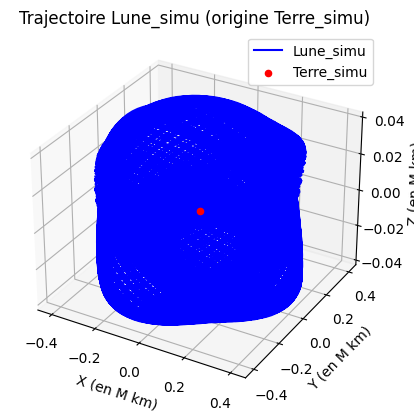

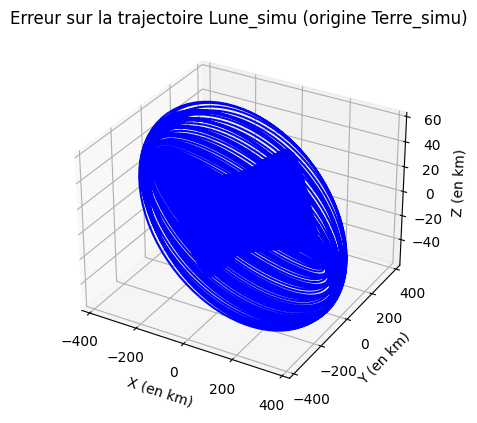

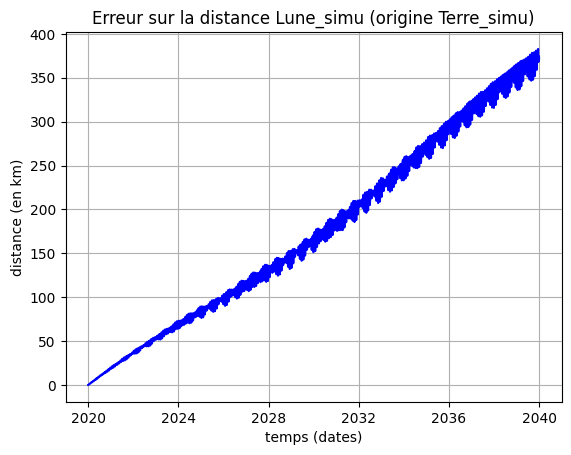

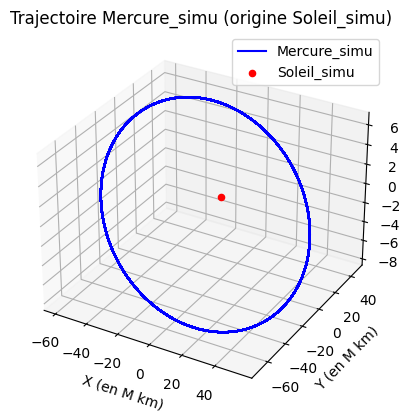

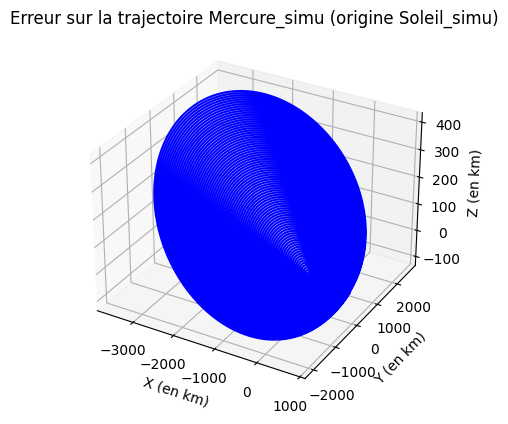

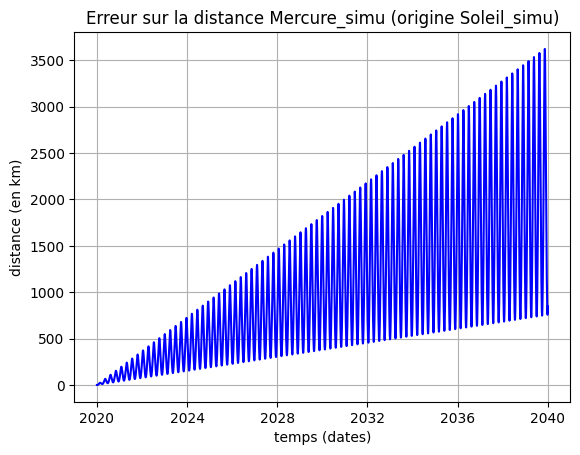

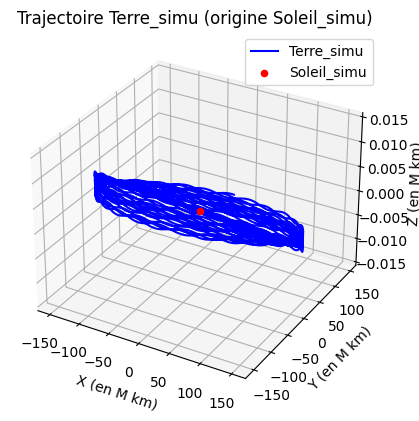

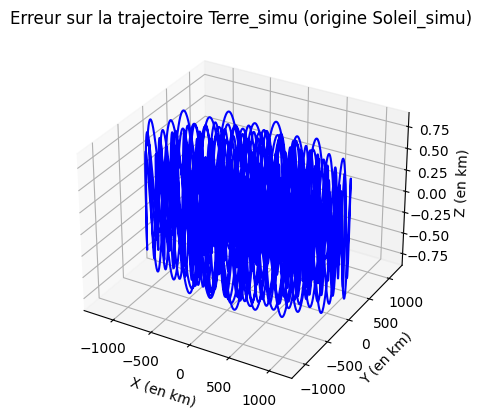

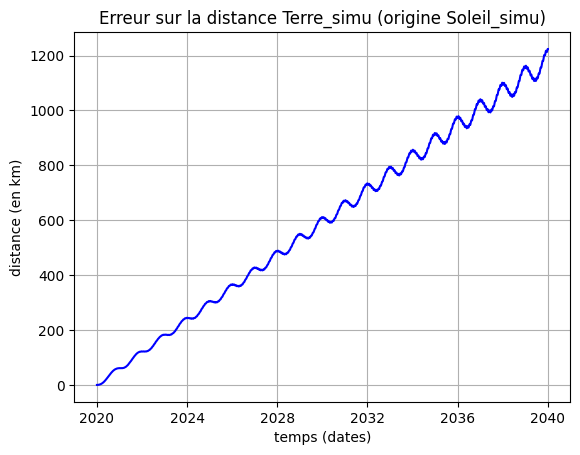

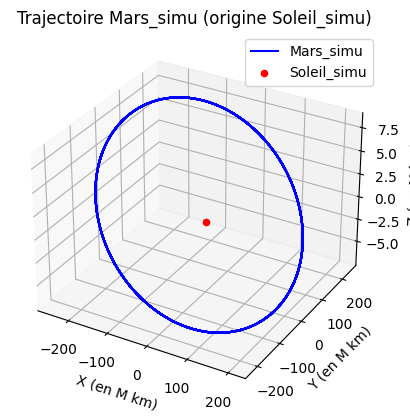

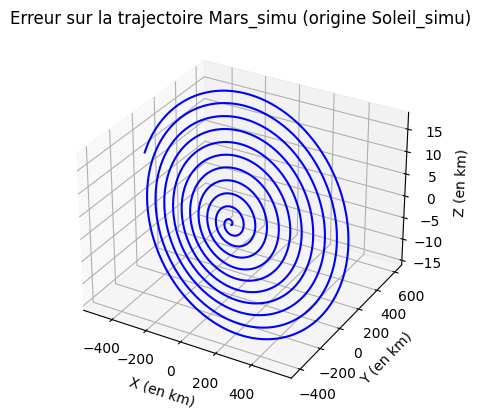

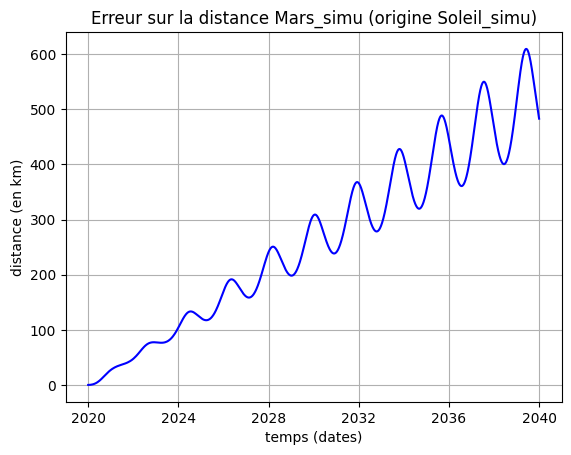

In [ ]:
compare(Astre1_a='Terre',Astre2_a='Lune',Astre1_b='Terre_simu',Astre2_b='Lune_simu')
compare(Astre1_a='Soleil',Astre2_a='Mercure',Astre1_b='Soleil_simu',Astre2_b='Mercure_simu')
compare(Astre1_a='Soleil',Astre2_a='Terre',Astre1_b='Soleil_simu',Astre2_b='Terre_simu')
compare(Astre1_a='Soleil',Astre2_a='Mars',Astre1_b='Soleil_simu',Astre2_b='Mars_simu')

## Génération d'une orbite de Kepler (couple Soleil-Mercure), avec la fonction **orbite_kepler**

In [ ]:
orbite_kepler(Astre1='Soleil',Astre2='Mercure',Planetes='Planetes.csv',
    Astre1_k='Soleil_k',Astre2_k='Mercure_k',Planetes_k='Planetes_sol_mer.csv')

              JDTDB                DATES    X    Y    Z   VX   VY   VZ
0      2.458850e+06  2020-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
1      2.458850e+06  2020-01-01 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
2      2.458850e+06  2020-01-01 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
3      2.458850e+06  2020-01-02 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
4      2.458851e+06  2020-01-02 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
...             ...                  ...  ...  ...  ...  ...  ...  ...
21911  2.466153e+06  2039-12-30 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21912  2.466154e+06  2039-12-31 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21913  2.466154e+06  2039-12-31 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21914  2.466154e+06  2039-12-31 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21915  2.466154e+06  2040-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0

[21916 rows x 8 columns]
              JDTDB                DATES             X             Y  \
0      2.458850e+06  2020-01-01 00:00:00 -9.474763

## Simulation numérique d'une orbite de Kepler (couple Soleil-Mercure)

In [ ]:
simu_systsol_save(Planetes='Planetes_sol_mer.csv',methode='rk8')

Soleil_k : 132712462073.14796 km^3 s^-2
Mercure_k : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:10.099543 (hh:mm:ss.ms)


## Comparaison entre la solution exacte pour l'orbite de Kepler et la simulation numérique

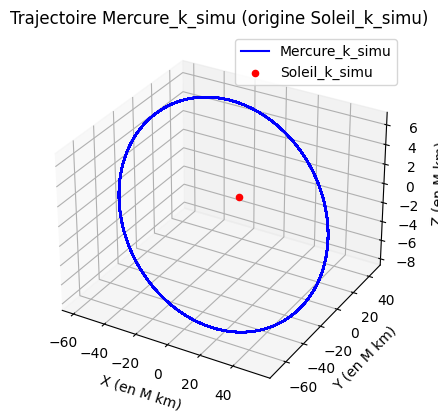

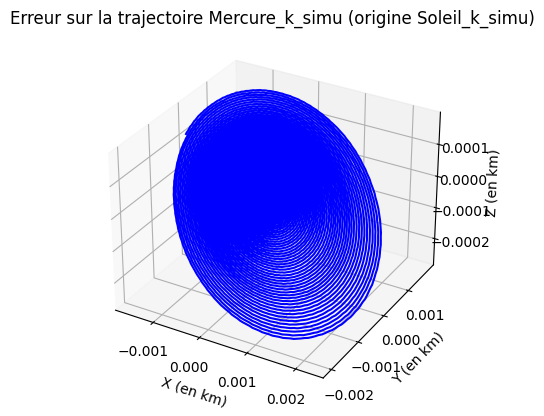

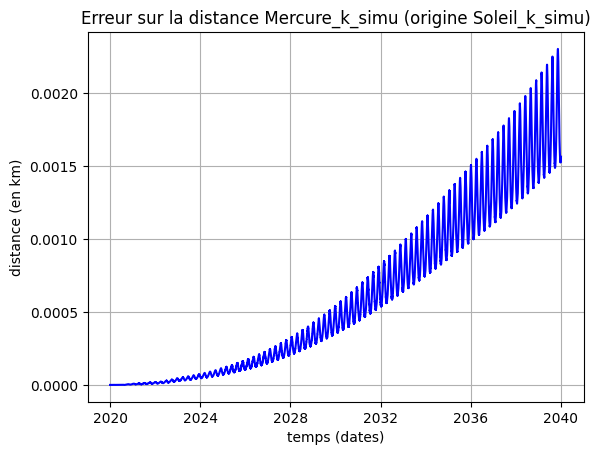

In [ ]:
compare(Astre1_a='Soleil_k',Astre2_a='Mercure_k',Astre1_b='Soleil_k_simu',Astre2_b='Mercure_k_simu')

## Génération d'une orbite de Kepler (couple Terre-Lune)

In [ ]:
orbite_kepler(Astre1='Terre',Astre2='Lune',Planetes='Planetes.csv',
    Astre1_k='Terre_k',Astre2_k='Lune_k',Planetes_k='Planetes_ter_lun.csv')

              JDTDB                DATES    X    Y    Z   VX   VY   VZ
0      2.458850e+06  2020-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
1      2.458850e+06  2020-01-01 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
2      2.458850e+06  2020-01-01 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
3      2.458850e+06  2020-01-02 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
4      2.458851e+06  2020-01-02 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
...             ...                  ...  ...  ...  ...  ...  ...  ...
21911  2.466153e+06  2039-12-30 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21912  2.466154e+06  2039-12-31 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21913  2.466154e+06  2039-12-31 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21914  2.466154e+06  2039-12-31 16:00:00  0.0  0.0  0.0  0.0  0.0  0.0
21915  2.466154e+06  2040-01-01 00:00:00  0.0  0.0  0.0  0.0  0.0  0.0

[21916 rows x 8 columns]
              JDTDB                DATES              X              Y  \
0      2.458850e+06  2020-01-01 00:00:00  390185

## Simulation numérique d'une orbite de Kepler (couple Terre-Lune)

In [ ]:
simu_systsol_save(Planetes='Planetes_ter_lun.csv',methode='rk8')

Terre_k : 403503.235625 km^3 s^-2
Lune_k : 0.0 km^3 s^-2
début de la simulation numérique
fin de la simulation à 0:00:10.154456 (hh:mm:ss.ms)


## Comparaison entre la solution exacte pour l'orbite de Kepler et la simulation numérique

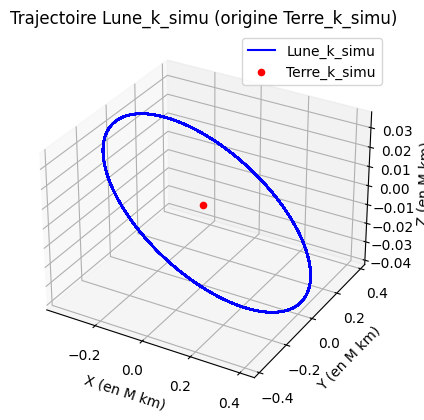

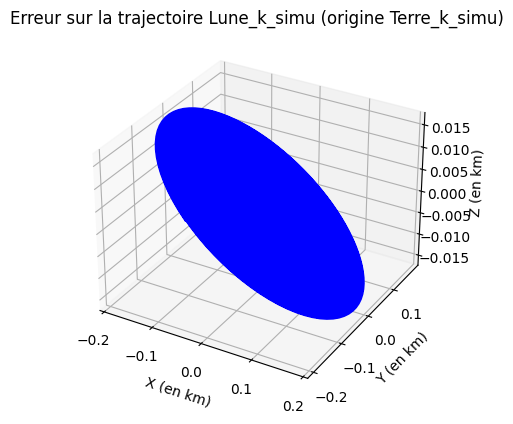

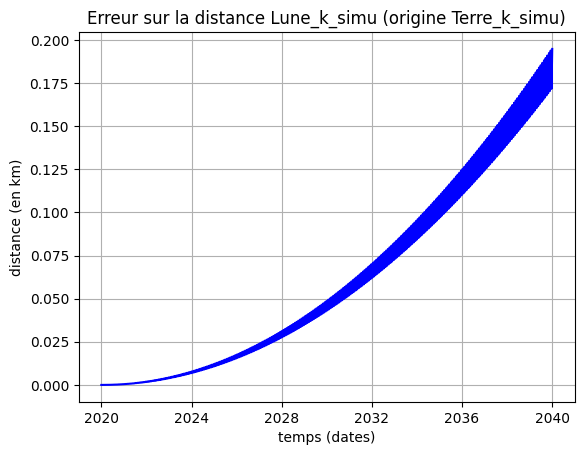

In [ ]:
compare(Astre1_a='Terre_k',Astre2_a='Lune_k',Astre1_b='Terre_k_simu',Astre2_b='Lune_k_simu')

## Comparaison des paramètres orbitaux calculés sur les données JPL et les données simulées, avec la fonction **param_orb_comp**

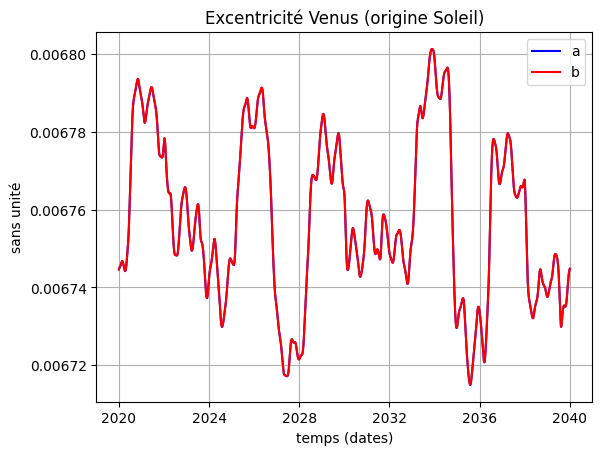

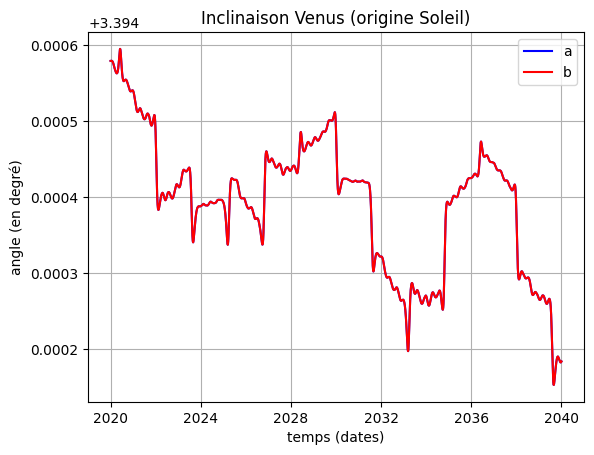

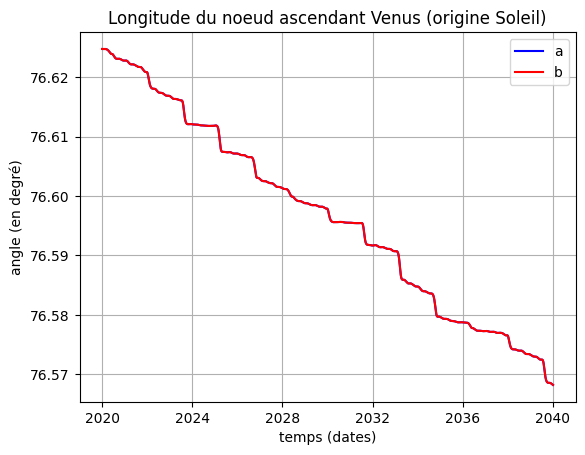

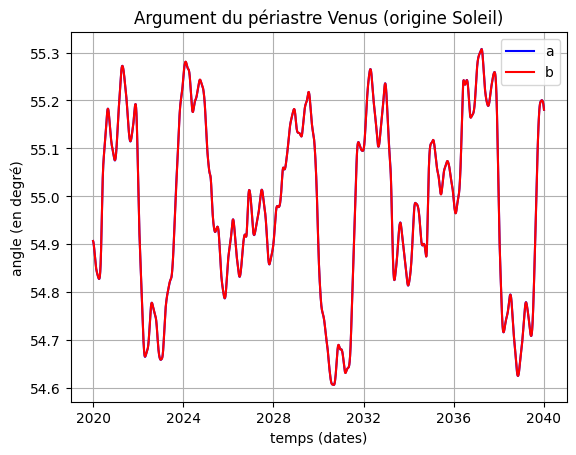

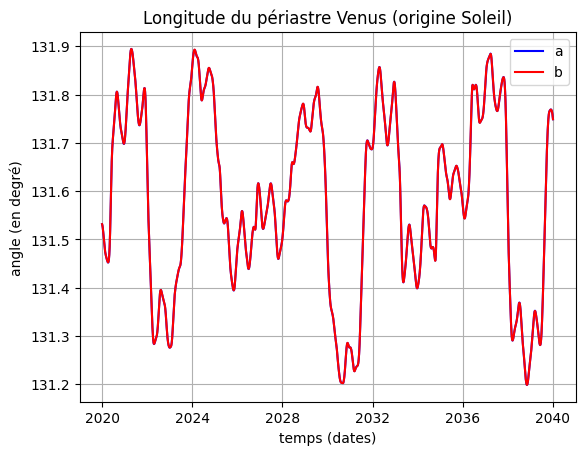

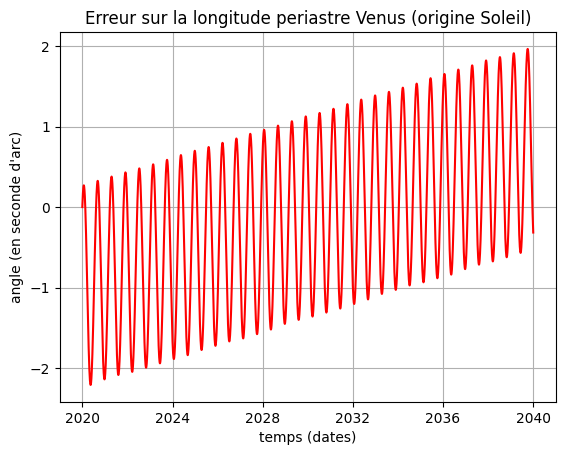

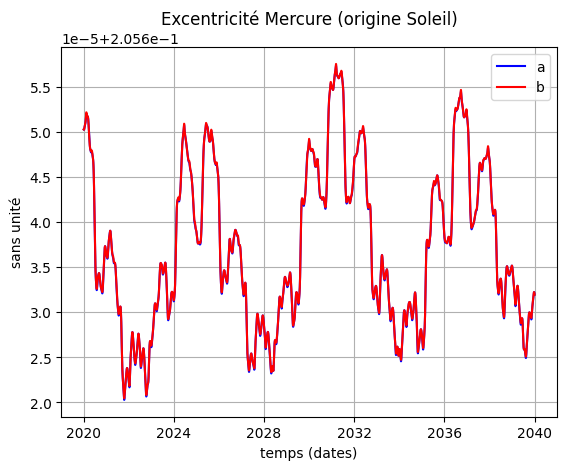

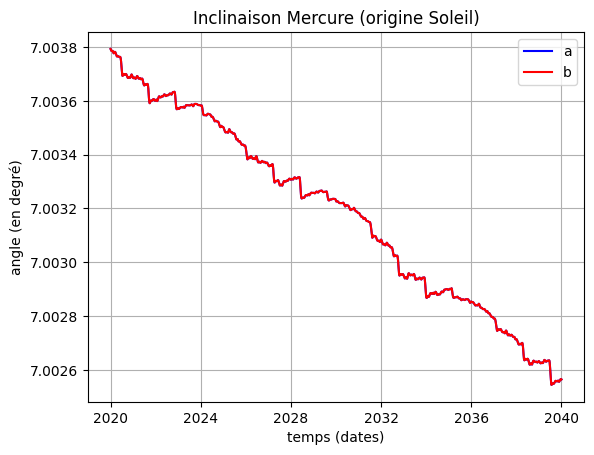

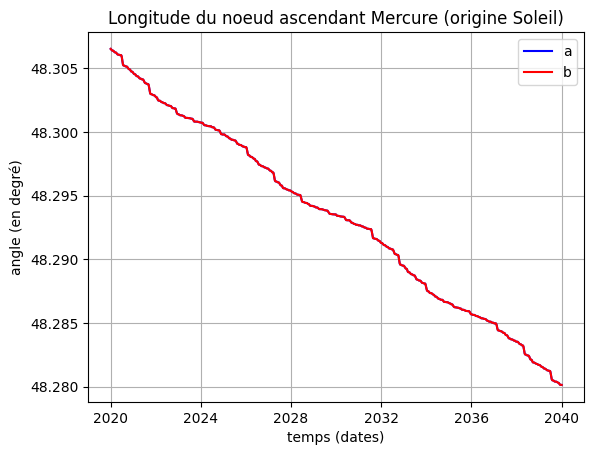

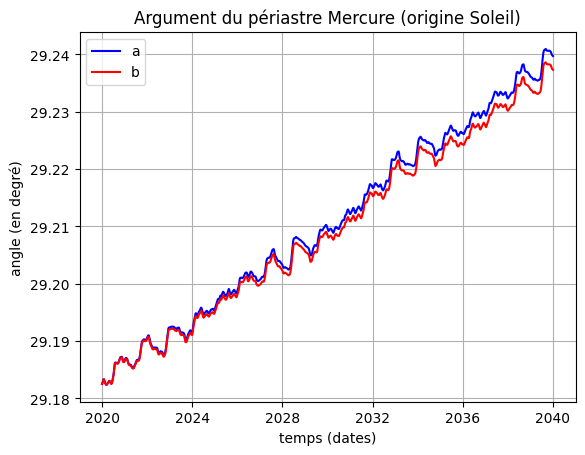

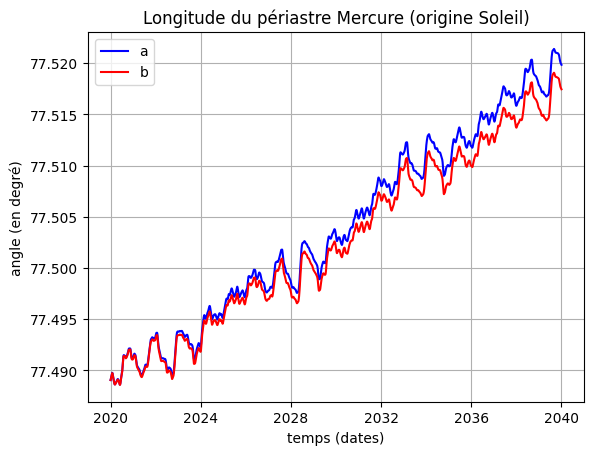

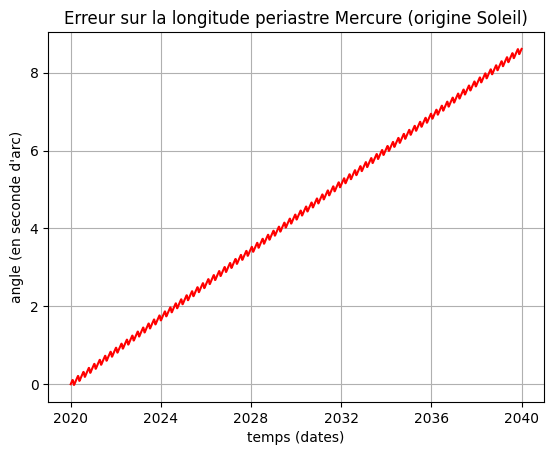

In [ ]:
param_orb_comp(Astre1_a='Soleil',Astre2_a='Venus',Astre1_b='Soleil_simu',Astre2_b='Venus_simu',
    Planetes='Planetes.csv')
param_orb_comp(Astre1_a='Soleil',Astre2_a='Mercure',Astre1_b='Soleil_simu',Astre2_b='Mercure_simu',
    Planetes='Planetes.csv')

## Liste des fichiers sur **Google Colab** après exécution complète

In [ ]:
!pwd
!ls -lart *.csv

/content
-rw-r--r-- 1 root root     340 Sep  6 07:54 Planetes.csv
-rw-r--r-- 1 root root 3398131 Sep  6 07:54 Soleil.csv
-rw-r--r-- 1 root root 3200432 Sep  6 07:55 Mercure.csv
-rw-r--r-- 1 root root 3199549 Sep  6 07:55 Venus.csv
-rw-r--r-- 1 root root 3259975 Sep  6 07:55 Terre.csv
-rw-r--r-- 1 root root 3234509 Sep  6 07:55 Lune.csv
-rw-r--r-- 1 root root 3216728 Sep  6 07:55 Mars.csv
-rw-r--r-- 1 root root 3217239 Sep  6 07:55 Jupiter.csv
-rw-r--r-- 1 root root 3214357 Sep  6 07:55 Saturne.csv
-rw-r--r-- 1 root root 3221218 Sep  6 07:55 Uranus.csv
-rw-r--r-- 1 root root 3237885 Sep  6 07:55 Neptune.csv
-rw-r--r-- 1 root root 3463584 Sep  6 07:59 Soleil_simu.csv
-rw-r--r-- 1 root root 3253295 Sep  6 07:59 Mercure_simu.csv
-rw-r--r-- 1 root root 3263637 Sep  6 07:59 Venus_simu.csv
-rw-r--r-- 1 root root 3339910 Sep  6 07:59 Terre_simu.csv
-rw-r--r-- 1 root root 3304934 Sep  6 07:59 Lune_simu.csv
-rw-r--r-- 1 root root 3285202 Sep  6 07:59 Mars_simu.csv
-rw-r--r-- 1 root root 3279743 